In [4]:
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import ResNet50V2
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Flatten, Dropout, BatchNormalization
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping
from sklearn.metrics import confusion_matrix, classification_report
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
import os

In [7]:
train_dir = 'E:/Music Chord/Data70_30_ (75)/Train'
test_dir = 'E:/Music Chord/Data70_30_ (75)/Validation'


In [8]:
# Image data generators for training, validation, and test
train_datagen = ImageDataGenerator(
    rescale=1.0/255.0,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True
)

test_datagen = ImageDataGenerator(rescale=1.0/255.0)

training_set = train_datagen.flow_from_directory(
    train_dir,
    target_size=(224, 224),  # ResNet50V2 input size
    batch_size=32,
    class_mode='categorical'
)

test_set = test_datagen.flow_from_directory(
    test_dir,
    target_size=(224, 224),
    batch_size=32,
    class_mode='categorical',
    shuffle=False  # Do not shuffle for evaluation
)

Found 624 images belonging to 12 classes.
Found 276 images belonging to 12 classes.


In [4]:
# Load the ResNet50V2 model with pre-trained weights, excluding the top layers
base_model = ResNet50V2(weights='imagenet', include_top=False, input_shape=(224, 224, 3))


94668760/94668760 ━━━━━━━━━━━━━━━━━━━━ 114s 1us/step


In [5]:
# Freeze the base model's layers
for layer in base_model.layers:
    layer.trainable = False

In [6]:
# Create a new model with additional layers
model = Sequential([
    base_model,
    Flatten(),
    Dense(128, activation='relu'),
    BatchNormalization(),
    Dropout(0.3),
    Dense(12, activation='softmax')  # 15 classes
])

In [7]:
# Compile the model
model.compile(
    optimizer=Adam(learning_rate=0.0001),
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

In [9]:
# Define callbacks
checkpoint = ModelCheckpoint('best_model.keras', monitor='val_loss', save_best_only=True, mode='min')
early_stopping = EarlyStopping(monitor='val_loss', patience=15, mode='min', restore_best_weights=True)

In [12]:
history = model.fit(
    training_set,
    steps_per_epoch=training_set.samples // training_set.batch_size,
    epochs=15,
    validation_data=test_set,
    validation_steps=test_set.samples // test_set.batch_size,
    callbacks=[checkpoint, early_stopping]
)

Epoch 1/15
19/19 ━━━━━━━━━━━━━━━━━━━━ 65s 3s/step - accuracy: 0.4010 - loss: 1.7720 - val_accuracy: 0.4336 - val_loss: 2.0938
Epoch 2/15
19/19 ━━━━━━━━━━━━━━━━━━━━ 4s 79ms/step - accuracy: 0.3750 - loss: 1.8234 - val_accuracy: 0.4500 - val_loss: 1.3060
Epoch 3/15
19/19 ━━━━━━━━━━━━━━━━━━━━ 67s 3s/step - accuracy: 0.4690 - loss: 1.5282 - val_accuracy: 0.4805 - val_loss: 1.6374
Epoch 4/15
19/19 ━━━━━━━━━━━━━━━━━━━━ 3s 77ms/step - accuracy: 0.7500 - loss: 1.1038 - val_accuracy: 0.8500 - val_loss: 0.8751
Epoch 5/15
19/19 ━━━━━━━━━━━━━━━━━━━━ 65s 3s/step - accuracy: 0.5679 - loss: 1.2333 - val_accuracy: 0.5039 - val_loss: 1.5156
Epoch 6/15
19/19 ━━━━━━━━━━━━━━━━━━━━ 4s 77ms/step - accuracy: 0.6875 - loss: 0.9550 - val_accuracy: 0.4500 - val_loss: 1.4392
Epoch 7/15
19/19 ━━━━━━━━━━━━━━━━━━━━ 67s 3s/step - accuracy: 0.6326 - loss: 1.0708 - val_accuracy: 0.5469 - val_loss: 1.3663
Epoch 8/15
19/19 ━━━━━━━━━━━━━━━━━━━━ 4s 80ms/step - accuracy: 0.7188 - loss: 1.0526 - val_accuracy: 0.6500 - val_l

In [13]:
# Evaluate the model on the test set
loss, accuracy = model.evaluate(test_set, steps=test_set.samples // test_set.batch_size)
print(f'Test Loss: {loss:.4f}')
print(f'Test Accuracy: {accuracy:.4f}')

8/8 ━━━━━━━━━━━━━━━━━━━━ 18s 2s/step - accuracy: 0.8386 - loss: 0.6359
Test Loss: 0.5850
Test Accuracy: 0.8477


In [14]:
model.save('E:/Music Chord/Models/ResNet50V2.h5')
print("Model saved to disk.")

Model saved to disk.


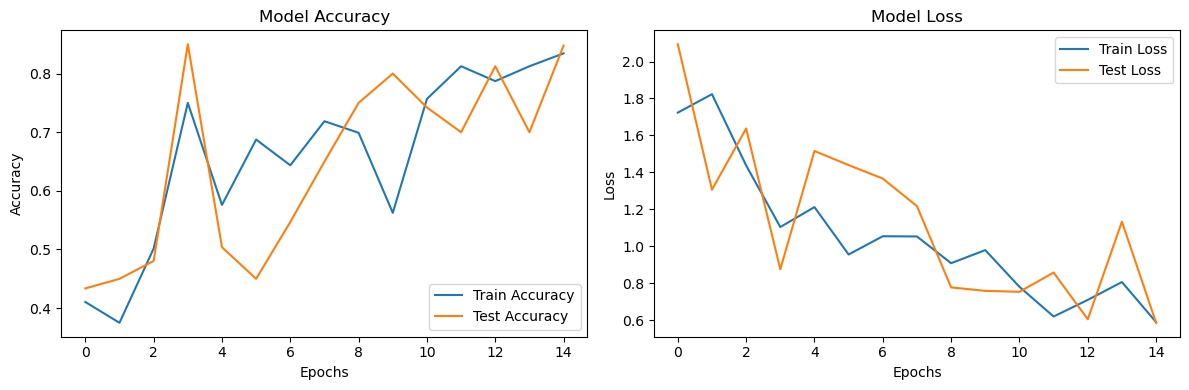

In [15]:
# Plot accuracy and loss graphs
plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Test Accuracy')
plt.title('Model Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Test Loss')
plt.title('Model Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.tight_layout()
plt.show()


9/9 ━━━━━━━━━━━━━━━━━━━━ 25s 3s/step


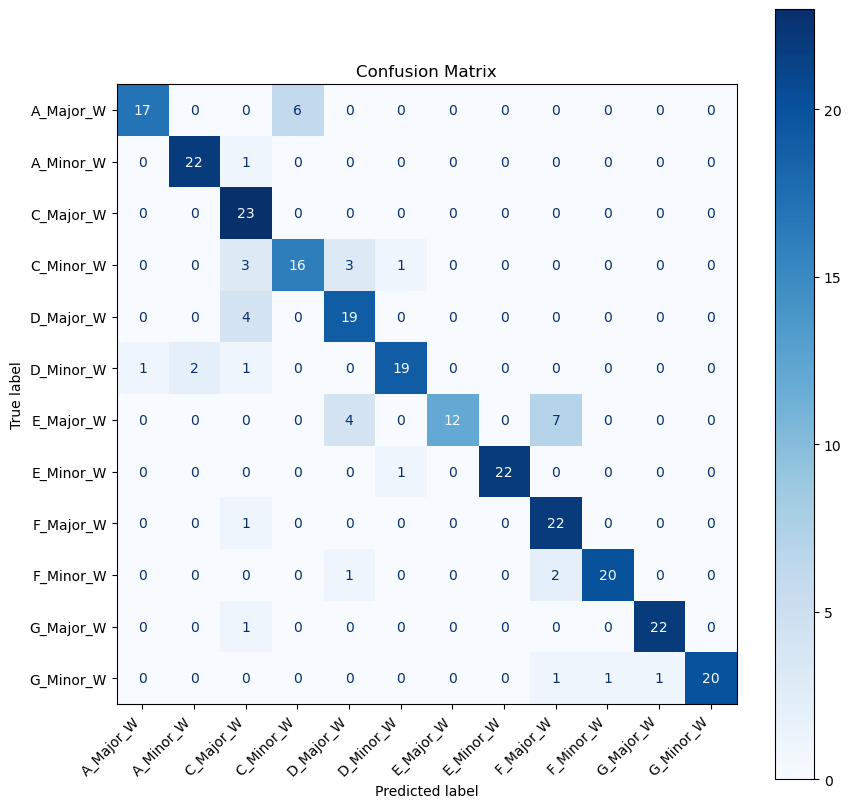

In [16]:

from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt
import numpy as np

# Generate confusion matrix
test_set.reset()
Y_pred = model.predict(test_set)
y_pred = np.argmax(Y_pred, axis=1)
y_true = test_set.classes

cm = confusion_matrix(y_true, y_pred)
labels = list(test_set.class_indices.keys())

# Plot the confusion matrix with a larger figure size
fig, ax = plt.subplots(figsize=(10, 10))  # Adjust the figure size as needed
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=labels)
disp.plot(cmap=plt.cm.Blues, ax=ax)
plt.xticks(rotation=45, ha='right')  # Rotate the x-axis labels for better readability
plt.yticks(rotation=0)  # Ensure y-axis labels are readable
plt.title('Confusion Matrix')
plt.show()



Piano Dataset of sub_classes Confusion Matrix and Accuracy

1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 104ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 99ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 103ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 109ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 112ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 109ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 123ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 133ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 145ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 149ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 110ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 127ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 159ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 109ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 125ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 127ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 118ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 121ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 119ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 109ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 152ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 140ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 110ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 101ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 1

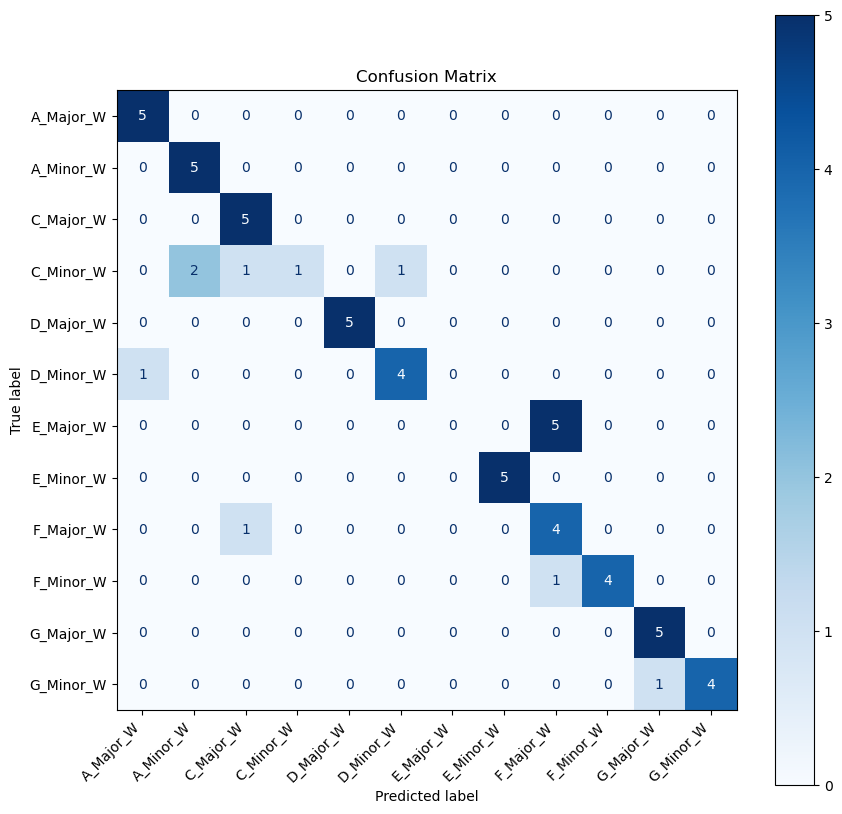

Accuracy: 78.33%


In [20]:
import os
import tensorflow as tf
from tensorflow.keras.preprocessing import image
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

# Load the trained model
model = tf.keras.models.load_model('E:/Music Chord/Models/ResNet50V2.h5')

# Define the class labels (Ensure these match the classes from your training data)
class_labels = list(training_set.class_indices.keys())

# Function to load and preprocess an image
def load_and_preprocess_image(img_path, target_size=(224, 224)):
    img = image.load_img(img_path, target_size=target_size)
    img_array = image.img_to_array(img)
    img_array = np.expand_dims(img_array, axis=0)
    img_array /= 255.0  # Rescale the image
    return img_array

# Function to classify the image
def classify_image(img_path):
    img_array = load_and_preprocess_image(img_path)
    predictions = model.predict(img_array)
    predicted_class_index = np.argmax(predictions, axis=1)[0]
    predicted_class_name = class_labels[predicted_class_index]
    return predicted_class_name

# Function to generate confusion matrix and display it along with accuracy
def display_confusion_matrix_and_accuracy(folder_path):
    true_labels = []
    predicted_labels = []

    for class_name in os.listdir(folder_path):
        class_folder = os.path.join(folder_path, class_name)
        if os.path.isdir(class_folder):
            for img_name in os.listdir(class_folder):
                img_path = os.path.join(class_folder, img_name)
                if img_path.endswith(('png', 'jpg', 'jpeg')):
                    predicted_class_name = classify_image(img_path)
                    true_labels.append(class_name)
                    predicted_labels.append(predicted_class_name)

    # Generate confusion matrix
    cm = confusion_matrix(true_labels, predicted_labels, labels=class_labels)
    accuracy = np.trace(cm) / np.sum(cm) * 100  # Compute accuracy

    # Display confusion matrix
    fig, ax = plt.subplots(figsize=(10, 10))  # Adjust the figure size as needed
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=class_labels)
    disp.plot(cmap=plt.cm.Blues, ax=ax)
    plt.xticks(rotation=45, ha='right')  # Rotate the x-axis labels for better readability
    plt.yticks(rotation=0)  # Ensure y-axis labels are readable
    plt.title(f'Confusion Matrix')  # Display accuracy in the title
    plt.show()

    return accuracy

# Example usage
test_folder_path = 'E:/Music Chord/Data70_30_ (75)/Test2'  # Replace with your folder path
accuracy = display_confusion_matrix_and_accuracy(test_folder_path)
print(f'Accuracy: {accuracy:.2f}%')


Guiter Dataset with sub_Folders , Confiction Matrix and accuracy

1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 107ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 123ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 120ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 132ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 114ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 118ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 129ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 149ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 122ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 115ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 125ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 130ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 103ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 113ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 126ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 107ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 96ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 109ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 128ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 126ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 128ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 121ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 118ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 127ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 1

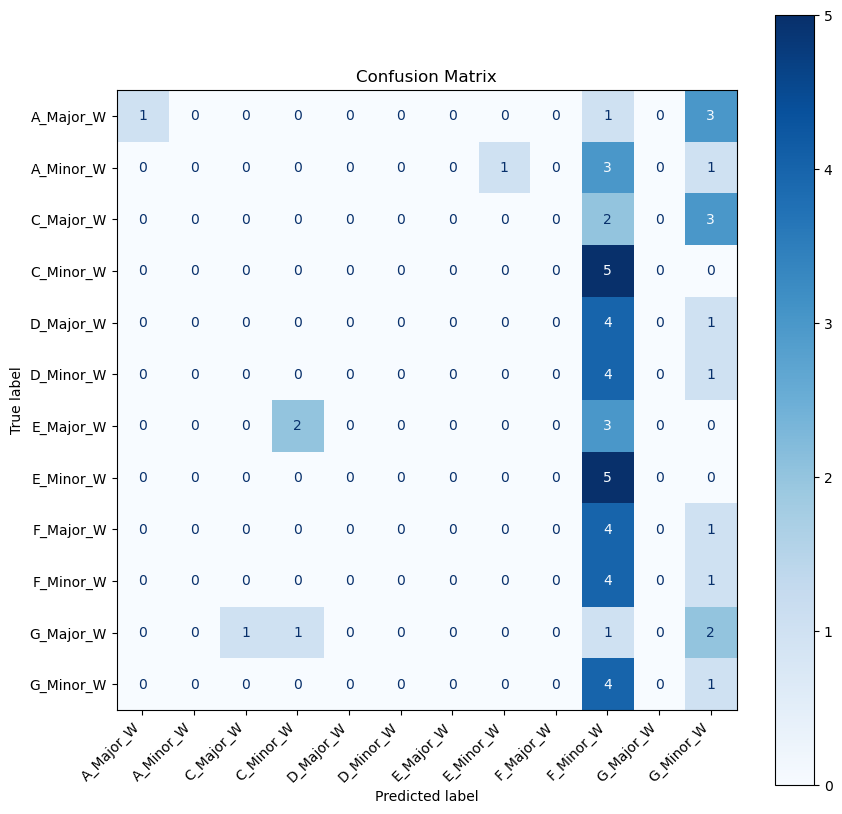

Accuracy: 10.00%


In [22]:
import os
import tensorflow as tf
from tensorflow.keras.preprocessing import image
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

# Load the trained model
model = tf.keras.models.load_model('E:/Music Chord/Models/ResNet50V2.h5')

# Define the class labels (Ensure these match the classes from your training data)
class_labels = list(training_set.class_indices.keys())

# Function to load and preprocess an image
def load_and_preprocess_image(img_path, target_size=(224, 224)):
    img = image.load_img(img_path, target_size=target_size)
    img_array = image.img_to_array(img)
    img_array = np.expand_dims(img_array, axis=0)
    img_array /= 255.0  # Rescale the image
    return img_array

# Function to classify the image
def classify_image(img_path):
    img_array = load_and_preprocess_image(img_path)
    predictions = model.predict(img_array)
    predicted_class_index = np.argmax(predictions, axis=1)[0]
    predicted_class_name = class_labels[predicted_class_index]
    return predicted_class_name

# Function to generate confusion matrix and display it along with accuracy
def display_confusion_matrix_and_accuracy(folder_path):
    true_labels = []
    predicted_labels = []

    for class_name in os.listdir(folder_path):
        class_folder = os.path.join(folder_path, class_name)
        if os.path.isdir(class_folder):
            for img_name in os.listdir(class_folder):
                img_path = os.path.join(class_folder, img_name)
                if img_path.endswith(('png', 'jpg', 'jpeg')):
                    predicted_class_name = classify_image(img_path)
                    true_labels.append(class_name)
                    predicted_labels.append(predicted_class_name)

    # Generate confusion matrix
    cm = confusion_matrix(true_labels, predicted_labels, labels=class_labels)
    accuracy = np.trace(cm) / np.sum(cm) * 100  # Compute accuracy

    # Display confusion matrix
    fig, ax = plt.subplots(figsize=(10, 10))  # Adjust the figure size as needed
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=class_labels)
    disp.plot(cmap=plt.cm.Blues, ax=ax)
    plt.xticks(rotation=45, ha='right')  # Rotate the x-axis labels for better readability
    plt.yticks(rotation=0)  # Ensure y-axis labels are readable
    plt.title(f'Confusion Matrix')  # Display accuracy in the title
    plt.show()

    return accuracy

# Example usage
test_folder_path = 'E:\Music Chord\Giter_dataset(5)'  # Replace with your folder path
accuracy = display_confusion_matrix_and_accuracy(test_folder_path)
print(f'Accuracy: {accuracy:.2f}%')


1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 115ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 114ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 125ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 231ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 137ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 148ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 120ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 203ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 158ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 269ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 164ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 163ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 122ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 120ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 111ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 132ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 223ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 130ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 177ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 182ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 125ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 123ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 261ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 119ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 

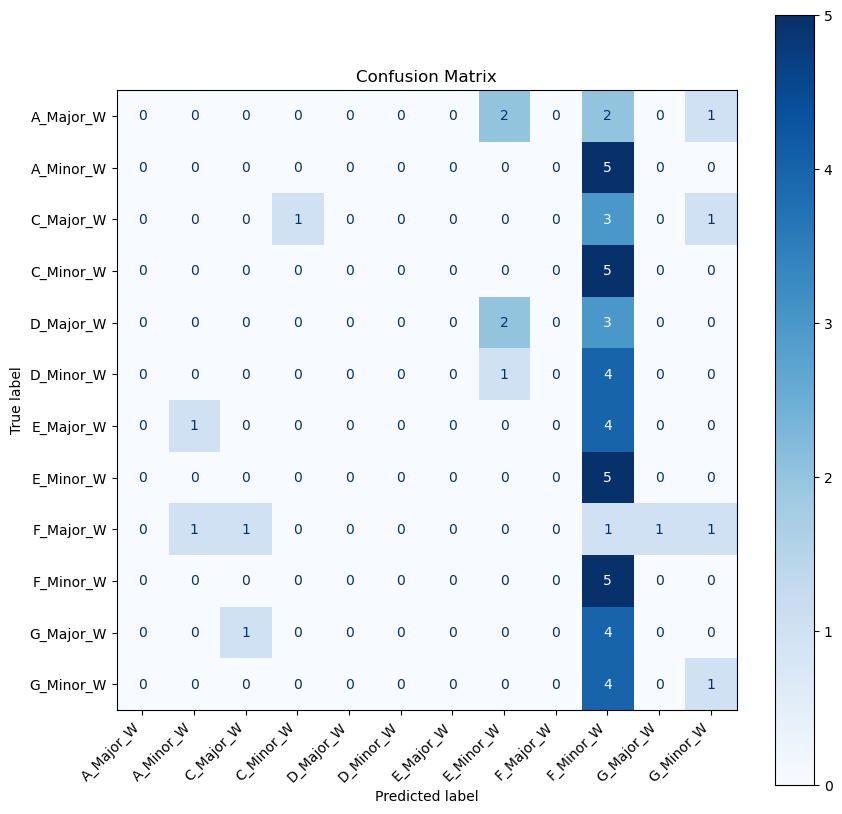

Accuracy: 10.00%


In [9]:
import os
import tensorflow as tf
from tensorflow.keras.preprocessing import image
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

# Load the trained model
model = tf.keras.models.load_model('E:/Music Chord/Models/ResNet50V2.h5')

# Define the class labels (Ensure these match the classes from your training data)
class_labels = list(training_set.class_indices.keys())

# Function to load and preprocess an image
def load_and_preprocess_image(img_path, target_size=(224, 224)):
    img = image.load_img(img_path, target_size=target_size)
    img_array = image.img_to_array(img)
    img_array = np.expand_dims(img_array, axis=0)
    img_array /= 255.0  # Rescale the image
    return img_array

# Function to classify the image
def classify_image(img_path):
    img_array = load_and_preprocess_image(img_path)
    predictions = model.predict(img_array)
    predicted_class_index = np.argmax(predictions, axis=1)[0]
    predicted_class_name = class_labels[predicted_class_index]
    return predicted_class_name

# Function to generate confusion matrix and display it along with accuracy
def display_confusion_matrix_and_accuracy(folder_path):
    true_labels = []
    predicted_labels = []

    for class_name in os.listdir(folder_path):
        class_folder = os.path.join(folder_path, class_name)
        if os.path.isdir(class_folder):
            for img_name in os.listdir(class_folder):
                img_path = os.path.join(class_folder, img_name)
                if img_path.endswith(('png', 'jpg', 'jpeg')):
                    predicted_class_name = classify_image(img_path)
                    true_labels.append(class_name)
                    predicted_labels.append(predicted_class_name)

    # Generate confusion matrix
    cm = confusion_matrix(true_labels, predicted_labels, labels=class_labels)
    accuracy = np.trace(cm) / np.sum(cm) * 100  # Compute accuracy

    # Display confusion matrix
    fig, ax = plt.subplots(figsize=(10, 10))  # Adjust the figure size as needed
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=class_labels)
    disp.plot(cmap=plt.cm.Blues, ax=ax)
    plt.xticks(rotation=45, ha='right')  # Rotate the x-axis labels for better readability
    plt.yticks(rotation=0)  # Ensure y-axis labels are readable
    plt.title(f'Confusion Matrix')  # Display accuracy in the title
    plt.show()

    return accuracy

# Example usage
test_folder_path = 'E:/Music Chord/New'  # Replace with your folder path
accuracy = display_confusion_matrix_and_accuracy(test_folder_path)
print(f'Accuracy: {accuracy:.2f}%')


Dataset of both Guiter And Piano

1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 117ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 136ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 122ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 117ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 117ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 100ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 118ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 112ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 115ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 116ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 108ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 100ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 119ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 108ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 124ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 111ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 104ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 114ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 121ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 109ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 111ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 124ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 115ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 117ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 

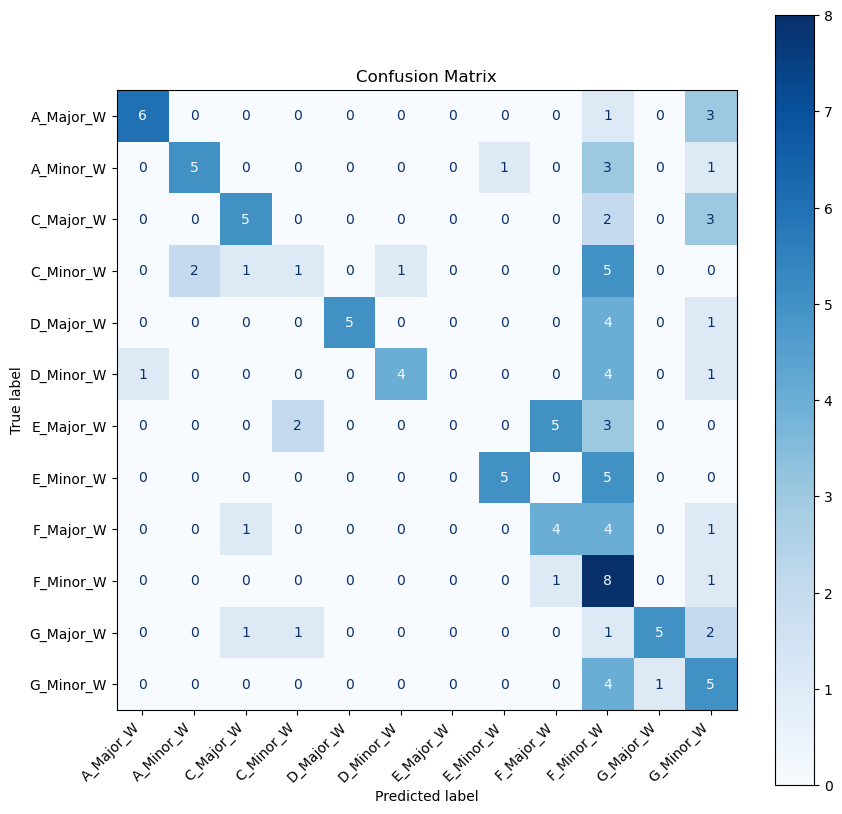

Accuracy: 44.17%


In [23]:
import os
import tensorflow as tf
from tensorflow.keras.preprocessing import image
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

# Load the trained model
model = tf.keras.models.load_model('E:/Music Chord/Models/ResNet50V2.h5')

# Define the class labels (Ensure these match the classes from your training data)
class_labels = list(training_set.class_indices.keys())

# Function to load and preprocess an image
def load_and_preprocess_image(img_path, target_size=(224, 224)):
    img = image.load_img(img_path, target_size=target_size)
    img_array = image.img_to_array(img)
    img_array = np.expand_dims(img_array, axis=0)
    img_array /= 255.0  # Rescale the image
    return img_array

# Function to classify the image
def classify_image(img_path):
    img_array = load_and_preprocess_image(img_path)
    predictions = model.predict(img_array)
    predicted_class_index = np.argmax(predictions, axis=1)[0]
    predicted_class_name = class_labels[predicted_class_index]
    return predicted_class_name

# Function to generate confusion matrix and display it along with accuracy
def display_confusion_matrix_and_accuracy(folder_path):
    true_labels = []
    predicted_labels = []

    for class_name in os.listdir(folder_path):
        class_folder = os.path.join(folder_path, class_name)
        if os.path.isdir(class_folder):
            for img_name in os.listdir(class_folder):
                img_path = os.path.join(class_folder, img_name)
                if img_path.endswith(('png', 'jpg', 'jpeg')):
                    predicted_class_name = classify_image(img_path)
                    true_labels.append(class_name)
                    predicted_labels.append(predicted_class_name)

    # Generate confusion matrix
    cm = confusion_matrix(true_labels, predicted_labels, labels=class_labels)
    accuracy = np.trace(cm) / np.sum(cm) * 100  # Compute accuracy

    # Display confusion matrix
    fig, ax = plt.subplots(figsize=(10, 10))  # Adjust the figure size as needed
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=class_labels)
    disp.plot(cmap=plt.cm.Blues, ax=ax)
    plt.xticks(rotation=45, ha='right')  # Rotate the x-axis labels for better readability
    plt.yticks(rotation=0)  # Ensure y-axis labels are readable
    plt.title(f'Confusion Matrix')  # Display accuracy in the title
    plt.show()

    return accuracy

# Example usage
test_folder_path = 'E:\Music Chord\Both'  # Replace with your folder path
accuracy = display_confusion_matrix_and_accuracy(test_folder_path)
print(f'Accuracy: {accuracy:.2f}%')


Images of all classes in single folder -Piano

Files in directory 'E:/Music Chord/Data70_30_ (75)/Test3': ['A_Major_W.png', 'A_Minor_W.png', 'C_Major_W.png', 'C_Minor_W.png', 'D_Major_W.png', 'D_Minor_W.png', 'E_Major_W.png', 'E_Minor_W.png', 'F_Major_W.png', 'F_Minor_W.png', 'G_Major_W.png', 'G_Minor_W.png']
Number of test images: 12
Number of test labels: 12
Test labels: [ 0  1  2  3  4  5  6  7  8  9 10 11]
1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step
True labels: [ 0  1  2  3  4  5  6  7  8  9 10 11]
Predicted labels: [ 0  2  2  5  4  5  8  7  2 11 10 11]
Accuracy: 58.33%


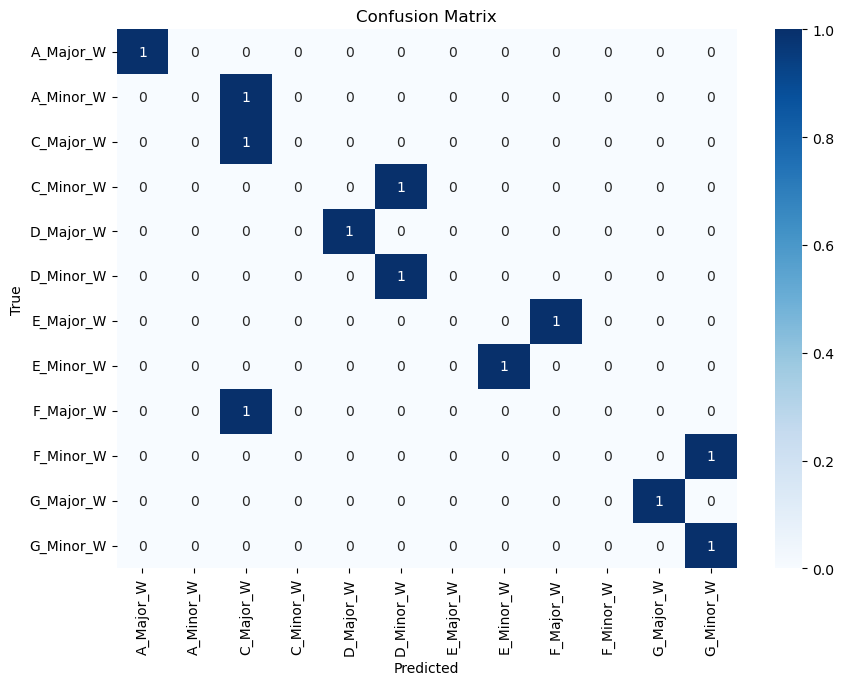

              precision    recall  f1-score   support

   A_Major_W       1.00      1.00      1.00         1
   A_Minor_W       0.00      0.00      0.00         1
   C_Major_W       0.33      1.00      0.50         1
   C_Minor_W       0.00      0.00      0.00         1
   D_Major_W       1.00      1.00      1.00         1
   D_Minor_W       0.50      1.00      0.67         1
   E_Major_W       0.00      0.00      0.00         1
   E_Minor_W       1.00      1.00      1.00         1
   F_Major_W       0.00      0.00      0.00         1
   F_Minor_W       0.00      0.00      0.00         1
   G_Major_W       1.00      1.00      1.00         1
   G_Minor_W       0.50      1.00      0.67         1

    accuracy                           0.58        12
   macro avg       0.44      0.58      0.49        12
weighted avg       0.44      0.58      0.49        12



c:\ProgramData\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\ProgramData\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\ProgramData\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [24]:
import os
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from tensorflow.keras.preprocessing.image import load_img, img_to_array
from tensorflow.keras.models import load_model
from sklearn.metrics import confusion_matrix, accuracy_score, classification_report
from tensorflow.keras.applications.inception_v3 import preprocess_input

# Set up paths and parameters
test_dir = 'E:/Music Chord/Data70_30_ (75)/Test3'
model_path = 'E:/Music Chord/Models/ResNet50V2.h5'
image_size = (224, 224)  # Adjust to 300x300 based on the trained model

# Load your trained model
model = load_model(model_path)

# Load and preprocess test images
test_images = []
test_labels = []  # This should be a list of true labels for each test image
class_labels = ['A_Major_W', 'A_Minor_W', 'C_Major_W', 'C_Minor_W', 'D_Major_W', 'D_Minor_W',
                'E_Major_W', 'E_Minor_W', 'F_Major_W', 'F_Minor_W', 'G_Major_W', 'G_Minor_W']  # Define your classes here

# Print debug information about the files in the test directory
print(f"Files in directory '{test_dir}': {os.listdir(test_dir)}")

# Manually load images and their labels
for img_name in os.listdir(test_dir):
    img_path = os.path.join(test_dir, img_name)

    # Check if the path is a file and is an image
    if os.path.isfile(img_path) and img_name.lower().endswith(('.png', '.jpg', '.jpeg')):
        try:
            # Load and preprocess the image
            img = load_img(img_path, target_size=image_size)
            img = img_to_array(img)
            img = preprocess_input(img)
            test_images.append(img)

            # Extract the label from the filename by removing the extension
            label_name = os.path.splitext(img_name)[0]  # Extract the class part of the filename

            # Check if the entire filename (without extension) matches a class label
            if label_name in class_labels:
                test_labels.append(class_labels.index(label_name))
            else:
                print(f"Warning: '{label_name}' extracted from '{img_name}' is not in class_labels")
        except Exception as e:
            print(f"Error processing file {img_path}: {e}")
    else:
        print(f"Skipping non-image file {img_path}")

# Convert to numpy arrays
test_images = np.array(test_images)
test_labels = np.array(test_labels)

# Debug prints
print(f'Number of test images: {len(test_images)}')
print(f'Number of test labels: {len(test_labels)}')
print(f'Test labels: {test_labels}')

# Ensure there are test images before proceeding
if len(test_images) == 0 or len(test_labels) == 0:
    raise ValueError("No valid test images or labels found. Please check the test directory and file formats.")

# Predict the classes of test images
predictions = model.predict(test_images)
y_pred = np.argmax(predictions, axis=1)
y_true = test_labels

# Debug: Print out the true labels and predicted labels
print(f'True labels: {y_true}')
print(f'Predicted labels: {y_pred}')

# Calculate accuracy
accuracy = accuracy_score(y_true, y_pred)
print(f'Accuracy: {accuracy * 100:.2f}%')

# Generate the confusion matrix
conf_matrix = confusion_matrix(y_true, y_pred)

# Plot confusion matrix
plt.figure(figsize=(10, 7))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=class_labels, yticklabels=class_labels)
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.show()

# Print classification report
report = classification_report(y_true, y_pred, target_names=class_labels)
print(report)


60 Images of all classes in single folder -Piano

Number of test images: 60
Number of test labels: 60
Test labels: [ 0  0  0  0  0  1  1  1  1  1  2  2  2  2  2  3  3  3  3  3  4  4  4  4
  4  5  5  5  5  5  6  6  6  6  6  7  7  7  7  7  8  8  8  8  8  9  9  9
  9  9 10 10 10 10 10 11 11 11 11 11]
Unique test labels: [ 0  1  2  3  4  5  6  7  8  9 10 11]
2/2 ━━━━━━━━━━━━━━━━━━━━ 7s 3s/step
Accuracy: 70.00%


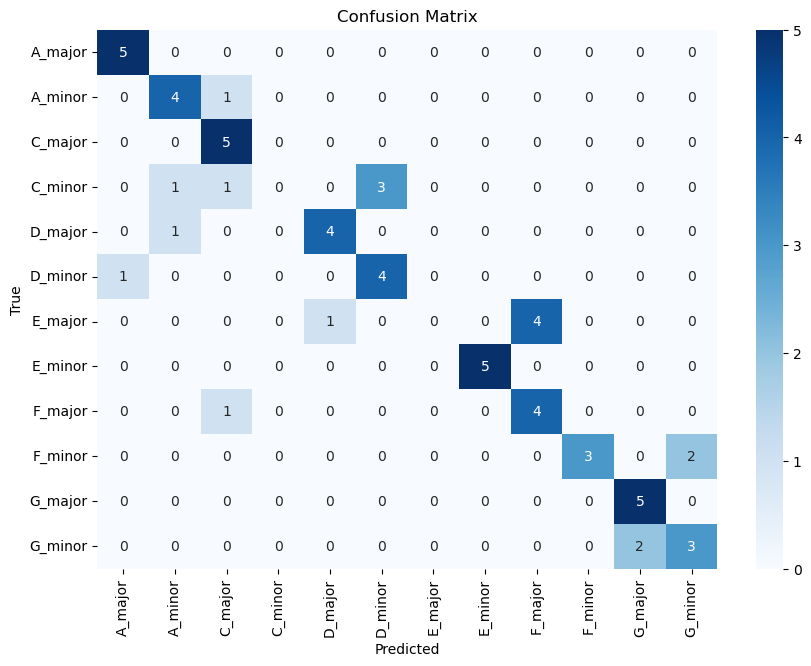

              precision    recall  f1-score   support

     A_major       0.83      1.00      0.91         5
     A_minor       0.67      0.80      0.73         5
     C_major       0.62      1.00      0.77         5
     C_minor       0.00      0.00      0.00         5
     D_major       0.80      0.80      0.80         5
     D_minor       0.57      0.80      0.67         5
     E_major       0.00      0.00      0.00         5
     E_minor       1.00      1.00      1.00         5
     F_major       0.50      0.80      0.62         5
     F_minor       1.00      0.60      0.75         5
     G_major       0.71      1.00      0.83         5
     G_minor       0.60      0.60      0.60         5

    accuracy                           0.70        60
   macro avg       0.61      0.70      0.64        60
weighted avg       0.61      0.70      0.64        60

Misclassified sample: True label = A_minor, Predicted label = C_major
Misclassified sample: True label = C_minor, Predicted label = D

c:\ProgramData\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\ProgramData\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\ProgramData\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [25]:
import os
import re
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from tensorflow.keras.preprocessing.image import load_img, img_to_array
from tensorflow.keras.models import load_model
from sklearn.metrics import confusion_matrix, accuracy_score, classification_report
from tensorflow.keras.applications.inception_v3 import preprocess_input

# Set up paths and parameters
test_dir = 'E:/Music Chord/Data70_30_ (75)/Test'
model_path = 'E:/Music Chord/Models/ResNet50V2.h5'
image_size = (224, 224)  # Adjust to 300x300 based on the trained model

# Load your trained model
model = load_model(model_path)

# Define class labels
class_labels = ['A_major', 'A_minor', 'C_major', 'C_minor', 'D_major', 'D_minor',
                'E_major', 'E_minor', 'F_major', 'F_minor', 'G_major', 'G_minor']

# Function to clean up label names
def clean_label(label):
    # Remove numbers and special characters after underscore and parentheses
    clean_label = re.sub(r'_\s*\(\d+\)', '', label)
    return clean_label

# Load and preprocess test images
test_images = []
test_labels = []

# Manually load images and their labels
for img_name in os.listdir(test_dir):
    img_path = os.path.join(test_dir, img_name)

    # Check if the path is a file and is an image
    if os.path.isfile(img_path) and img_name.lower().endswith(('.png', '.jpg', '.jpeg')):
        try:
            # Load and preprocess the image
            img = load_img(img_path, target_size=image_size)
            img = img_to_array(img)
            img = preprocess_input(img)

            # Extract the label from the filename by removing the extension
            label_name = os.path.splitext(img_name)[0]  # Extract the class part of the filename
            clean_label_name = clean_label(label_name)  # Clean the label name

            # Check if the cleaned label is in the defined class labels
            if clean_label_name in class_labels:
                test_images.append(img)
                test_labels.append(class_labels.index(clean_label_name))
            else:
                print(f"Warning: '{clean_label_name}' extracted from '{img_name}' is not in class_labels")
        except Exception as e:
            print(f"Error processing file {img_path}: {e}")
    else:
        print(f"Skipping non-image file {img_path}")

# Convert lists to numpy arrays
test_images = np.array(test_images)
test_labels = np.array(test_labels)

# Ensure there are test images before proceeding
if len(test_images) == 0 or len(test_labels) == 0:
    raise ValueError("No valid test images or labels found. Please check the test directory and file formats.")

# Debug prints
print(f'Number of test images: {len(test_images)}')
print(f'Number of test labels: {len(test_labels)}')
print(f'Test labels: {test_labels}')
print(f'Unique test labels: {np.unique(test_labels)}')

# Verify that all unique test labels are within the class_labels index range
if not all(label in range(len(class_labels)) for label in test_labels):
    raise ValueError("Test labels contain invalid class indices. Please check the label extraction process.")

# Predict the classes of test images
predictions = model.predict(test_images)
y_pred = np.argmax(predictions, axis=1)

# Calculate accuracy
accuracy = accuracy_score(test_labels, y_pred)
print(f'Accuracy: {accuracy * 100:.2f}%')

# Generate the confusion matrix
conf_matrix = confusion_matrix(test_labels, y_pred)

# Plot confusion matrix
plt.figure(figsize=(10, 7))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=class_labels, yticklabels=class_labels)
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.show()

# Print classification report
report = classification_report(test_labels, y_pred, target_names=class_labels)
print(report)

# Additional debug: print misclassified samples
misclassified_indices = np.where(test_labels != y_pred)[0]
for idx in misclassified_indices:
    print(f'Misclassified sample: True label = {class_labels[test_labels[idx]]}, Predicted label = {class_labels[y_pred[idx]]}')


60 images of Guiter in single folder 

Number of test images: 60
Number of test labels: 60
Test labels: [ 0  0  0  0  0  1  1  1  1  1  2  2  2  2  2  3  3  3  3  3  4  4  4  4
  4  5  5  5  5  5  6  6  6  6  6  7  7  7  7  7  8  8  8  8  8  9  9  9
  9  9 10 10 10 10 10 11 11 11 11 11]
Unique test labels: [ 0  1  2  3  4  5  6  7  8  9 10 11]


1/2 ━━━━━━━━━━━━━━━━━━━━ 3s 4s/stepWARNING:tensorflow:6 out of the last 125 calls to <function TensorFlowTrainer.make_predict_function.<locals>.one_step_on_data_distributed at 0x000001B95640A8E0> triggered tf.function retracing. Tracing is expensive and the excessive number of tracings could be due to (1) creating @tf.function repeatedly in a loop, (2) passing tensors with different shapes, (3) passing Python objects instead of tensors. For (1), please define your @tf.function outside of the loop. For (2), @tf.function has reduce_retracing=True option that can avoid unnecessary retracing. For (3), please refer to https://www.tensorflow.org/guide/function#controlling_retracing and https://www.tensorflow.org/api_docs/python/tf/function for  more details.


2/2 ━━━━━━━━━━━━━━━━━━━━ 7s 3s/step
Accuracy: 15.00%


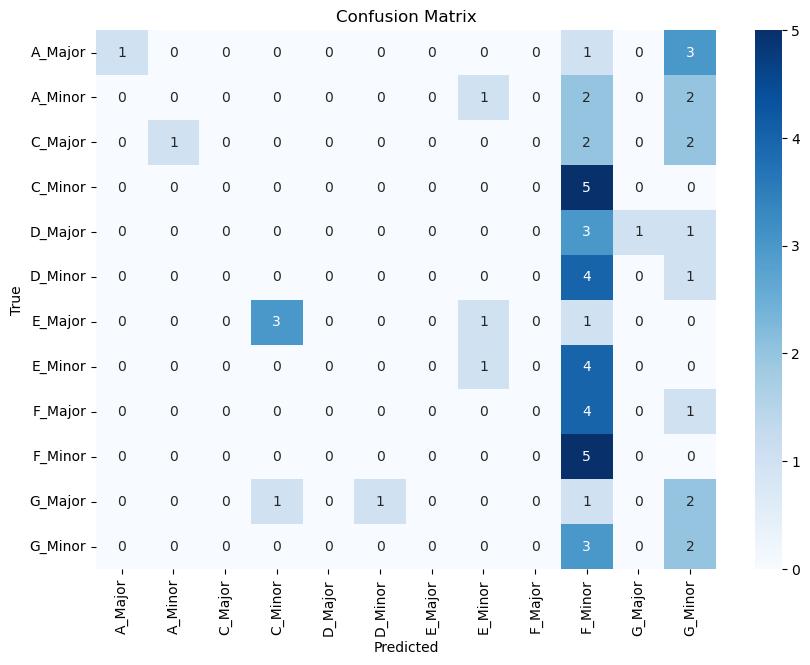

              precision    recall  f1-score   support

     A_Major       1.00      0.20      0.33         5
     A_Minor       0.00      0.00      0.00         5
     C_Major       0.00      0.00      0.00         5
     C_Minor       0.00      0.00      0.00         5
     D_Major       0.00      0.00      0.00         5
     D_Minor       0.00      0.00      0.00         5
     E_Major       0.00      0.00      0.00         5
     E_Minor       0.33      0.20      0.25         5
     F_Major       0.00      0.00      0.00         5
     F_Minor       0.14      1.00      0.25         5
     G_Major       0.00      0.00      0.00         5
     G_Minor       0.14      0.40      0.21         5

    accuracy                           0.15        60
   macro avg       0.13      0.15      0.09        60
weighted avg       0.13      0.15      0.09        60

Misclassified sample: True label = A_Major, Predicted label = G_Minor
Misclassified sample: True label = A_Major, Predicted label = F

c:\ProgramData\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\ProgramData\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\ProgramData\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [26]:
import os
import re
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from tensorflow.keras.preprocessing.image import load_img, img_to_array
from tensorflow.keras.models import load_model
from sklearn.metrics import confusion_matrix, accuracy_score, classification_report
from tensorflow.keras.applications.inception_v3 import preprocess_input

# Set up paths and parameters
test_dir = 'E:/Music Chord/Data70_30_ (75)/Test4'
model_path = 'E:/Music Chord/Models/ResNet50V2.h5'
image_size = (224, 224)  # Adjust to 300x300 based on the trained model

# Load your trained model
model = load_model(model_path)

# Define class labels
class_labels = ['A_Major', 'A_Minor', 'C_Major', 'C_Minor', 'D_Major', 'D_Minor',
                'E_Major', 'E_Minor', 'F_Major', 'F_Minor', 'G_Major', 'G_Minor']

# Function to clean up label names
def clean_label(label):
    # Remove numbers and special characters after underscore and parentheses
    clean_label = re.sub(r'_\s*\(\d+\)', '', label)
    return clean_label

# Load and preprocess test images
test_images = []
test_labels = []

# Manually load images and their labels
for img_name in os.listdir(test_dir):
    img_path = os.path.join(test_dir, img_name)

    # Check if the path is a file and is an image
    if os.path.isfile(img_path) and img_name.lower().endswith(('.png', '.jpg', '.jpeg')):
        try:
            # Load and preprocess the image
            img = load_img(img_path, target_size=image_size)
            img = img_to_array(img)
            img = preprocess_input(img)

            # Extract the label from the filename by removing the extension
            label_name = os.path.splitext(img_name)[0]  # Extract the class part of the filename
            clean_label_name = clean_label(label_name)  # Clean the label name

            # Check if the cleaned label is in the defined class labels
            if clean_label_name in class_labels:
                test_images.append(img)
                test_labels.append(class_labels.index(clean_label_name))
            else:
                print(f"Warning: '{clean_label_name}' extracted from '{img_name}' is not in class_labels")
        except Exception as e:
            print(f"Error processing file {img_path}: {e}")
    else:
        print(f"Skipping non-image file {img_path}")

# Convert lists to numpy arrays
test_images = np.array(test_images)
test_labels = np.array(test_labels)

# Ensure there are test images before proceeding
if len(test_images) == 0 or len(test_labels) == 0:
    raise ValueError("No valid test images or labels found. Please check the test directory and file formats.")

# Debug prints
print(f'Number of test images: {len(test_images)}')
print(f'Number of test labels: {len(test_labels)}')
print(f'Test labels: {test_labels}')
print(f'Unique test labels: {np.unique(test_labels)}')

# Verify that all unique test labels are within the class_labels index range
if not all(label in range(len(class_labels)) for label in test_labels):
    raise ValueError("Test labels contain invalid class indices. Please check the label extraction process.")

# Predict the classes of test images
predictions = model.predict(test_images)
y_pred = np.argmax(predictions, axis=1)

# Calculate accuracy
accuracy = accuracy_score(test_labels, y_pred)
print(f'Accuracy: {accuracy * 100:.2f}%')

# Generate the confusion matrix
conf_matrix = confusion_matrix(test_labels, y_pred)

# Plot confusion matrix
plt.figure(figsize=(10, 7))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=class_labels, yticklabels=class_labels)
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.show()

# Print classification report
report = classification_report(test_labels, y_pred, target_names=class_labels)
print(report)

# Additional debug: print misclassified samples
misclassified_indices = np.where(test_labels != y_pred)[0]
for idx in misclassified_indices:
    print(f'Misclassified sample: True label = {class_labels[test_labels[idx]]}, Predicted label = {class_labels[y_pred[idx]]}')


30-30 Images of Panio and Guiter

Number of test images: 60
Number of test labels: 60
Test labels: [ 0  0  0  0  0  1  1  1  1  1  2  2  2  2  2  3  3  3  3  3  4  4  4  4
  4  5  5  5  5  5  6  6  6  6  6  7  7  7  7  7  8  8  8  8  8  9  9  9
  9  9 10 10 10 10 10 11 11 11 11 11]
Unique test labels: [ 0  1  2  3  4  5  6  7  8  9 10 11]
2/2 ━━━━━━━━━━━━━━━━━━━━ 7s 4s/step
Accuracy: 50.00%


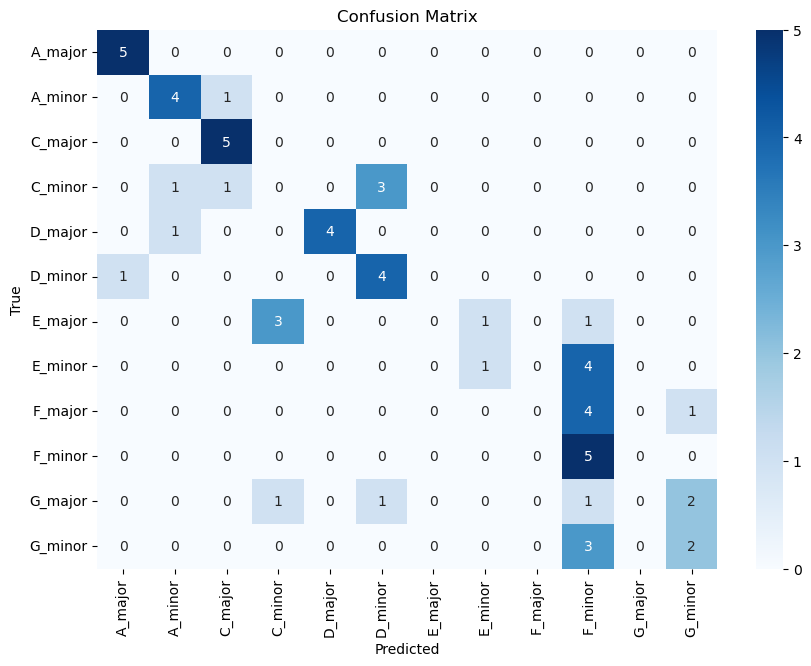

              precision    recall  f1-score   support

     A_major       0.83      1.00      0.91         5
     A_minor       0.67      0.80      0.73         5
     C_major       0.71      1.00      0.83         5
     C_minor       0.00      0.00      0.00         5
     D_major       1.00      0.80      0.89         5
     D_minor       0.50      0.80      0.62         5
     E_major       0.00      0.00      0.00         5
     E_minor       0.50      0.20      0.29         5
     F_major       0.00      0.00      0.00         5
     F_minor       0.28      1.00      0.43         5
     G_major       0.00      0.00      0.00         5
     G_minor       0.40      0.40      0.40         5

    accuracy                           0.50        60
   macro avg       0.41      0.50      0.42        60
weighted avg       0.41      0.50      0.42        60

Misclassified sample: True label = A_minor, Predicted label = C_major
Misclassified sample: True label = C_minor, Predicted label = D

c:\ProgramData\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\ProgramData\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\ProgramData\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [27]:
import os
import re
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from tensorflow.keras.preprocessing.image import load_img, img_to_array
from tensorflow.keras.models import load_model
from sklearn.metrics import confusion_matrix, accuracy_score, classification_report
from tensorflow.keras.applications.inception_v3 import preprocess_input

# Set up paths and parameters
test_dir = 'E:/Music Chord/Data70_30_ (75)/Test5'
model_path = 'E:/Music Chord/Models/ResNet50V2.h5'
image_size = (224, 224)  # Adjust to 300x300 based on the trained model

# Load your trained model
model = load_model(model_path)

# Define class labels
class_labels = ['A_major', 'A_minor', 'C_major', 'C_minor', 'D_major', 'D_minor',
                'E_major', 'E_minor', 'F_major', 'F_minor', 'G_major', 'G_minor']

# Function to clean up label names
def clean_label(label):
    # Remove numbers and special characters after underscore and parentheses
    clean_label = re.sub(r'_\s*\(\d+\)', '', label)
    return clean_label

# Load and preprocess test images
test_images = []
test_labels = []

# Manually load images and their labels
for img_name in os.listdir(test_dir):
    img_path = os.path.join(test_dir, img_name)

    # Check if the path is a file and is an image
    if os.path.isfile(img_path) and img_name.lower().endswith(('.png', '.jpg', '.jpeg')):
        try:
            # Load and preprocess the image
            img = load_img(img_path, target_size=image_size)
            img = img_to_array(img)
            img = preprocess_input(img)

            # Extract the label from the filename by removing the extension
            label_name = os.path.splitext(img_name)[0]  # Extract the class part of the filename
            clean_label_name = clean_label(label_name)  # Clean the label name

            # Check if the cleaned label is in the defined class labels
            if clean_label_name in class_labels:
                test_images.append(img)
                test_labels.append(class_labels.index(clean_label_name))
            else:
                print(f"Warning: '{clean_label_name}' extracted from '{img_name}' is not in class_labels")
        except Exception as e:
            print(f"Error processing file {img_path}: {e}")
    else:
        print(f"Skipping non-image file {img_path}")

# Convert lists to numpy arrays
test_images = np.array(test_images)
test_labels = np.array(test_labels)

# Ensure there are test images before proceeding
if len(test_images) == 0 or len(test_labels) == 0:
    raise ValueError("No valid test images or labels found. Please check the test directory and file formats.")

# Debug prints
print(f'Number of test images: {len(test_images)}')
print(f'Number of test labels: {len(test_labels)}')
print(f'Test labels: {test_labels}')
print(f'Unique test labels: {np.unique(test_labels)}')

# Verify that all unique test labels are within the class_labels index range
if not all(label in range(len(class_labels)) for label in test_labels):
    raise ValueError("Test labels contain invalid class indices. Please check the label extraction process.")

# Predict the classes of test images
predictions = model.predict(test_images)
y_pred = np.argmax(predictions, axis=1)

# Calculate accuracy
accuracy = accuracy_score(test_labels, y_pred)
print(f'Accuracy: {accuracy * 100:.2f}%')

# Generate the confusion matrix
conf_matrix = confusion_matrix(test_labels, y_pred)

# Plot confusion matrix
plt.figure(figsize=(10, 7))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=class_labels, yticklabels=class_labels)
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.show()

# Print classification report
report = classification_report(test_labels, y_pred, target_names=class_labels)
print(report)

# Additional debug: print misclassified samples
misclassified_indices = np.where(test_labels != y_pred)[0]
for idx in misclassified_indices:
    print(f'Misclassified sample: True label = {class_labels[test_labels[idx]]}, Predicted label = {class_labels[y_pred[idx]]}')
